In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
sns.set(style="ticks", color_codes=True)

data = pd.read_csv('Hospital_Readmissions_Reduction_Program.csv')

too_few = data[data['Number of Readmissions'] == 'Too Few to Report']
is_null = data.loc[pd.isnull(data['Number of Discharges']) 
                   & pd.isnull(data['Number of Readmissions'])]
not_null = data.loc[pd.notnull(data['Number of Discharges']) 
                    | pd.notnull(data['Number of Readmissions'])]
not_zero = not_null[not_null['Number of Discharges'] != 0]
clean_data = not_zero.replace('Too Few to Report', np.NaN)
clean_data['Number of Readmissions'] = clean_data['Number of Readmissions'].astype(float)

clean_data['Readmissions Rate'] = clean_data['Number of Readmissions'] / clean_data['Number of Discharges'] *100
clean_data['Actual Excess Readmission Ratio'] = clean_data['Readmissions Rate'] / clean_data['Expected Readmission Rate']

temp_ = clean_data.groupby('Facility ID').count().reset_index().copy()
type_fac = pd.DataFrame({'Facility ID': temp_['Facility ID'],
                         'Number of Departments': temp_['Facility Name']})
conditions = [type_fac['Number of Departments'] > 4,
             (type_fac['Number of Departments'] >= 3) & (type_fac['Number of Departments'] <= 4),
             type_fac['Number of Departments'] < 3]
values = ['General', 'Neither', 'Specialized']
type_fac['Type'] = np.select(conditions,values)
data_dept = pd.merge(clean_data, type_fac, on='Facility ID', how='left')


clean_readmission_rates = clean_data.loc[pd.notnull(clean_data['Readmissions Rate'])]
clean_data_dept = pd.merge(clean_readmission_rates, type_fac, on='Facility ID', how='left')


def filter(data, col_name, filter_value):
    return data[data[col_name] == filter_value]

diagnosis_lst = ['READM-30-AMI-HRRP',
                 'READM-30-CABG-HRRP',
                 'READM-30-COPD-HRRP',
                 'READM-30-HF-HRRP',
                 'READM-30-HIP-KNEE-HRRP',
                 'READM-30-PN-HRRP']

english_diagnosis_lst = ['Acute Myocardial Infarction (Heart Attack)',
                         'Coronary Artery Bypass Graft Surgery',
                         'Chronic Obstructive Pulmonary Disease',
                         'Heart Failure',
                         'Hip-Knee Replacement',
                         'Pneumonia']

type_lst = ['General','Neither','Specialized']

In [5]:
clean_data_dept;

In [6]:
d= {}
for name in diagnosis_lst:
    d[name] = filter(clean_data_dept, 'Measure Name', name)

In [7]:
d['READM-30-AMI-HRRP'];

In [8]:
def discharges_readmissions_by_type(measure_name):
    by_type_lst = []
    for type in type_lst:
        discharges = filter(d[measure_name], 'Type', type)['Number of Discharges'].sum()
        readmissions = filter(d[measure_name], 'Type', type)['Number of Readmissions'].sum()
        rate = readmissions / discharges *100
        by_type_lst.append([discharges, readmissions, rate])
    return by_type_lst

In [9]:
discharges_readmissions_by_type('READM-30-AMI-HRRP')

[[440926.0, 67121.0, 15.22273578786463],
 [9729.0, 1807.0, 18.573337444752802],
 [357.0, 41.0, 11.484593837535014]]

In [10]:
discharges_readmissions_by_type('READM-30-CABG-HRRP')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


[[103245.0, 13491.0, 13.066976609036757],
 [2180.0, 215.0, 9.862385321100918],
 [0.0, 0.0, nan]]

In [11]:
discharges_readmissions_by_type('READM-30-COPD-HRRP')

[[653792.0, 128693.0, 19.684089129264354],
 [95044.0, 18568.0, 19.53621480577417],
 [451.0, 77.0, 17.073170731707318]]

In [12]:
discharges_readmissions_by_type('READM-30-HF-HRRP')

[[1023907.0, 218306.0, 21.3208816816371],
 [105619.0, 23682.0, 22.422102083905358],
 [379.0, 90.0, 23.7467018469657]]

In [13]:
discharges_readmissions_by_type('READM-30-HIP-KNEE-HRRP')

[[722829.0, 29623.0, 4.098203032805823],
 [28162.0, 1196.0, 4.24685746750941],
 [81244.0, 2446.0, 3.010683865885481]]

In [14]:
discharges_readmissions_by_type('READM-30-PN-HRRP')

[[1074054.0, 179173.0, 16.681935917560942],
 [155415.0, 25316.0, 16.28928996557604],
 [2074.0, 378.0, 18.225650916104147]]

In [15]:
rate_lst = []
for type in type_lst:
    discharges = filter(clean_data_dept, 'Type', type)['Number of Discharges'].sum()
    readmissions = filter(clean_data_dept, 'Type', type)['Number of Readmissions'].sum()
    rate_lst.append(readmissions / discharges *100)
rate_lst

[15.835932190905986, 17.868024404958742, 3.5879533755399087]

In [16]:
def type_hospital_ttest(measure_name, type1, type2, variable):
    a = filter(d[measure_name], 'Type', type1)[variable]
    b = filter(d[measure_name], 'Type', type2)[variable]
    return stats.ttest_ind(a,b, equal_var=False,nan_policy='omit')[1]

In [17]:
for name in diagnosis_lst:
    print(name, ' : ', type_hospital_ttest(name, 'Specialized', 'General', 'Readmissions Rate'))

READM-30-AMI-HRRP  :  nan
READM-30-CABG-HRRP  :  nan
READM-30-COPD-HRRP  :  0.8721088542151331
READM-30-HF-HRRP  :  0.15146179984219685
READM-30-HIP-KNEE-HRRP  :  1.3143733193120622e-12
READM-30-PN-HRRP  :  0.024973922211598346


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
for name in diagnosis_lst:
    print(name, ' : ', type_hospital_ttest(name, 'Neither', 'Specialized', 'Readmissions Rate'))

READM-30-AMI-HRRP  :  nan
READM-30-CABG-HRRP  :  nan
READM-30-COPD-HRRP  :  0.9283843859436
READM-30-HF-HRRP  :  0.26162734686243244
READM-30-HIP-KNEE-HRRP  :  9.343168722009959e-07
READM-30-PN-HRRP  :  0.015930832079444148


In [19]:
for name in diagnosis_lst:
    print(name, ' : ', type_hospital_ttest(name, 'General', 'Neither', 'Readmissions Rate'))

READM-30-AMI-HRRP  :  2.4951032409721117e-11
READM-30-CABG-HRRP  :  0.0012511664682025223
READM-30-COPD-HRRP  :  0.19975345278472895
READM-30-HF-HRRP  :  4.915340956312958e-09
READM-30-HIP-KNEE-HRRP  :  0.4633321503727085
READM-30-PN-HRRP  :  0.10862771726619257


In [20]:
filter(d['READM-30-AMI-HRRP'], 'Type', 'Specialized')

,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date,Readmissions Rate,Actual Excess Readmission Ratio,Number of Departments,Type
10246,BAYLOR SCOTT AND WHITE HEART AND VASCULAR HOSP...,450851,TX,READM-30-AMI-HRRP,357.0,NaN,0.9309,12.617,13.5536,41.0,07/01/2015,06/30/2018,11.484594,0.847346,2,Specialized


In [21]:
filter(d['READM-30-CABG-HRRP'], 'Type', 'Specialized')

,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date,Readmissions Rate,Actual Excess Readmission Ratio,Number of Departments,Type


In [22]:
gen = filter(clean_data_dept, 'Type', 'General')['Readmissions Rate']
neith = filter(clean_data_dept, 'Type', 'Neither')['Readmissions Rate']
spec = filter(clean_data_dept, 'Type', 'Specialized')['Readmissions Rate']

stats.ttest_ind(gen,spec, equal_var=False,nan_policy='omit')[1]

3.0910084528714674e-14

In [23]:
np.mean(gen), np.mean(neith), np.mean(spec), [len(gen), len(neith), len(spec)]

(16.350144571405064, 19.04155396179361, 8.92421348733067, [8855, 2364, 109])

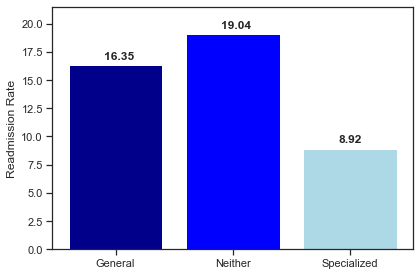

In [54]:
fig, axs = plt.subplots()

x = ['General','Neither','Specialized']
y = [np.mean(gen), np.mean(neith), np.mean(spec)]

axs.bar(x,y, color=['darkblue','blue','lightblue'])
axs.set_ylabel("Readmission Rate")

for i, v in enumerate(y):
    axs.text(i-.1, v+.5, str(round(v,2)), fontweight='bold')

axs.set_ylim([0,21.5])
    
plt.tight_layout()

fig.savefig('rrbytype.png')

In [147]:
stats.mannwhitneyu(gen,spec, alternative="greater")

MannwhitneyuResult(statistic=741084.5, pvalue=3.1049648245411184e-22)

In [150]:
stats.mannwhitneyu(neith,gen, alternative="greater")

MannwhitneyuResult(statistic=12648214.5, pvalue=4.010142941289472e-55)

In [148]:
stats.mannwhitneyu(neith,spec, alternative="greater")

MannwhitneyuResult(statistic=210747.5, pvalue=1.3276159282453314e-29)

In [89]:
def mean_hospital_rates(measure_name):
    mean_lst = []
    n_lst = []
    for type in type_lst:
        mean_lst.append(np.mean(filter(d[measure_name], 'Type', type)['Readmissions Rate']))
        n_lst.append(len(filter(d[measure_name], 'Type', type)['Readmissions Rate']))
    return mean_lst, n_lst

In [95]:
mean_hospital_rates('READM-30-AMI-HRRP')

([16.03054197026781, 22.317918626873535, 11.484593837535014], [1543, 81, 1])

In [96]:
mean_hospital_rates('READM-30-CABG-HRRP')

([13.985819639878791, 10.086131716503221, nan], [572, 7, 0])

In [97]:
mean_hospital_rates('READM-30-COPD-HRRP')

([19.35004435266229, 19.605730957186744, 19.928691359894962], [1848, 668, 5])

In [90]:
mean_hospital_rates('READM-30-HF-HRRP')

([21.196552048717702, 22.400259791284757, 25.980984746401305], [1884, 749, 6])

In [98]:
mean_hospital_rates('READM-30-HIP-KNEE-HRRP')

([4.645012631095612, 4.810197549861591, 3.4787177279885086], [1125, 62, 74])

In [99]:
mean_hospital_rates('READM-30-PN-HRRP')

([16.530371668704746, 16.265023994634078, 19.49131300575983], [1883, 797, 23])

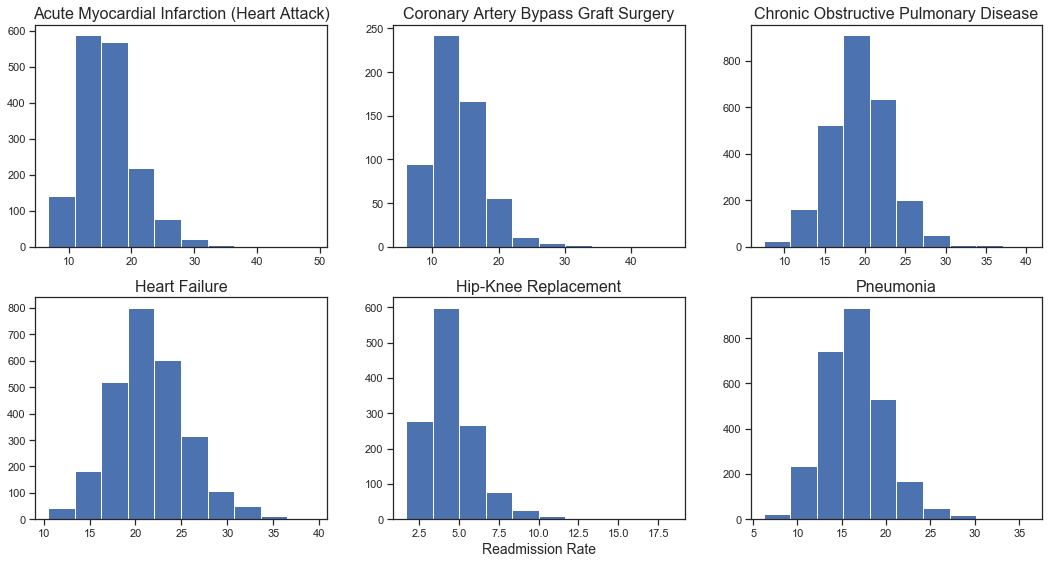

In [135]:
fig, ax = plt.subplots(2,3, figsize=(15,8))

for i, ax in enumerate(ax.flatten()):
    ax.set_title(english_diagnosis_lst[i], fontsize=16)
    ax.hist(d[diagnosis_lst[i]]['Readmissions Rate'])
    
    if i == 4:
        ax.set_xlabel('Readmission Rate', fontsize = 14)
    
plt.tight_layout()
fig.savefig('rates.png')

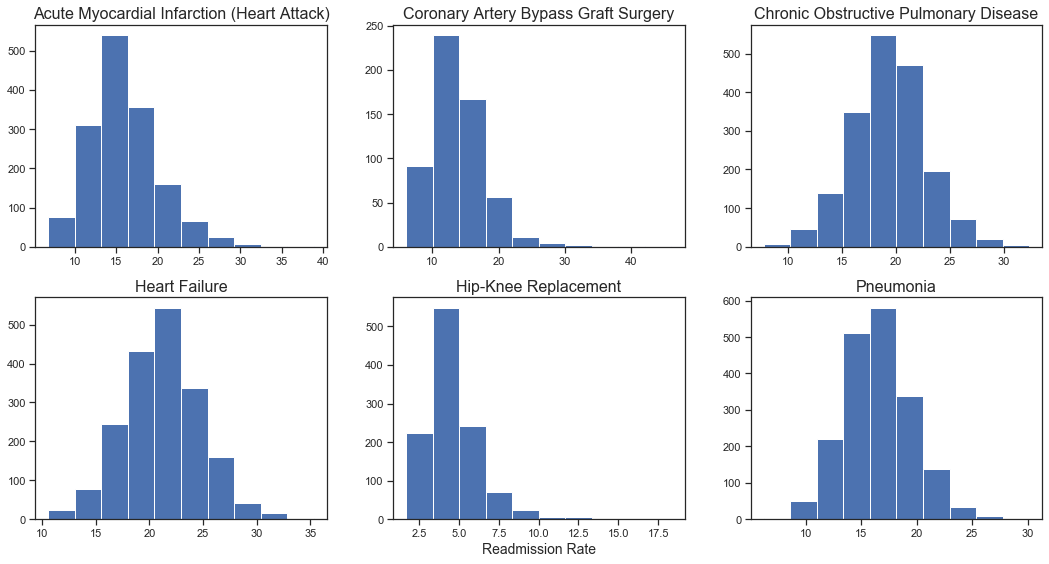

In [151]:
fig, ax = plt.subplots(2,3, figsize=(15,8))

for i, ax in enumerate(ax.flatten()):
    ax.set_title(english_diagnosis_lst[i], fontsize=16)
    ax.hist(filter(d[diagnosis_lst[i]],'Type', 'General')['Readmissions Rate'])
    
    if i == 4:
        ax.set_xlabel('Readmission Rate', fontsize = 14)
    
plt.tight_layout()
fig.savefig('general_rates.png')

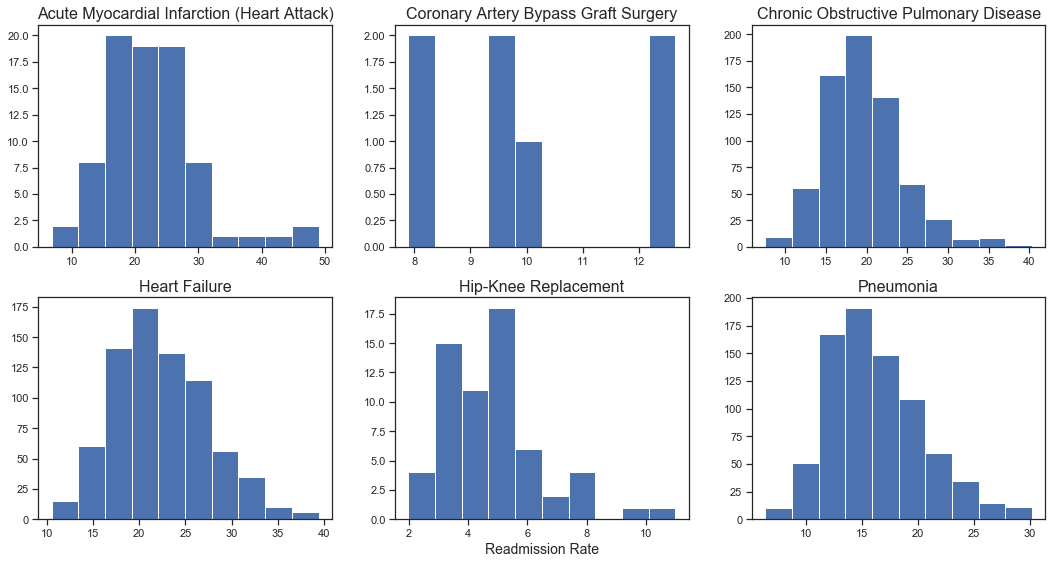

In [152]:
fig, ax = plt.subplots(2,3, figsize=(15,8))

for i, ax in enumerate(ax.flatten()):
    ax.set_title(english_diagnosis_lst[i], fontsize=16)
    ax.hist(filter(d[diagnosis_lst[i]],'Type','Neither')['Readmissions Rate'])
    
    if i == 4:
        ax.set_xlabel('Readmission Rate', fontsize = 14)
    
plt.tight_layout()
fig.savefig('neither_rates.png')

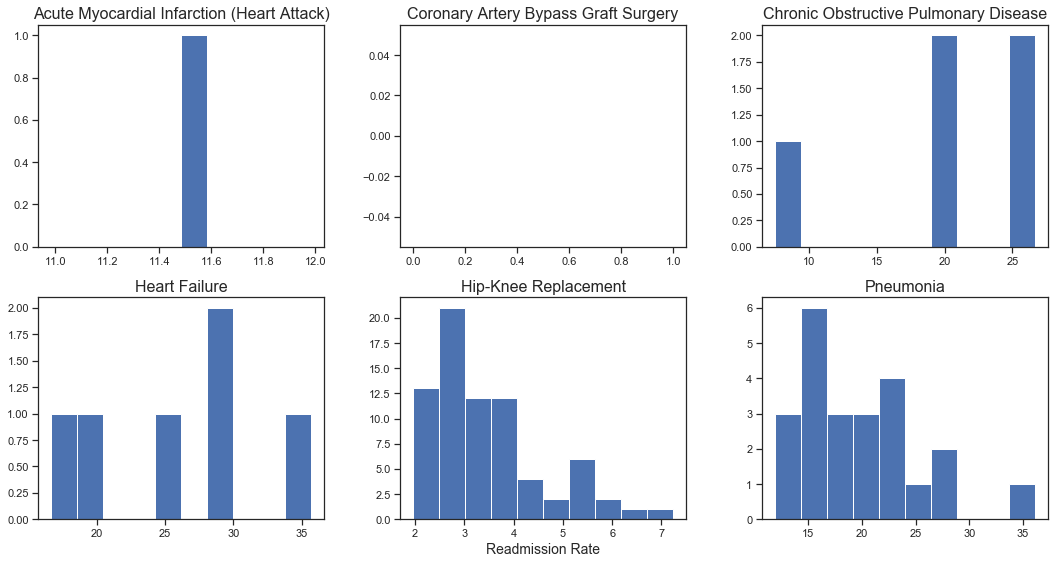

In [153]:
fig, ax = plt.subplots(2,3, figsize=(15,8))

for i, ax in enumerate(ax.flatten()):
    ax.set_title(english_diagnosis_lst[i], fontsize=16)
    ax.hist(filter(d[diagnosis_lst[i]],'Type','Specialized')['Readmissions Rate'])
    
    if i == 4:
        ax.set_xlabel('Readmission Rate', fontsize = 14)
    
plt.tight_layout()
fig.savefig('specialized_rates.png')

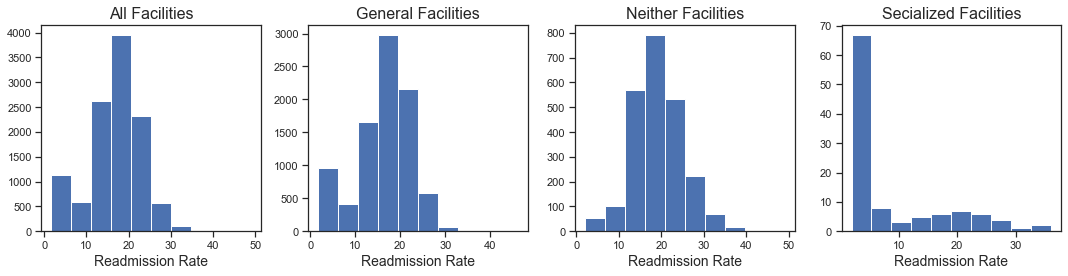

In [142]:
fig, ax = plt.subplots(1,4, figsize=(15,4))

ax[0].set_title('All Facilities', fontsize=16)
ax[0].hist(clean_data_dept['Readmissions Rate'])
ax[0].set_xlabel('Readmission Rate', fontsize=14)

ax[1].set_title('General Facilities', fontsize=16)
ax[1].hist(filter(clean_data_dept,'Type','General')['Readmissions Rate'])
ax[1].set_xlabel('Readmission Rate', fontsize=14)

ax[2].set_title('Neither Facilities', fontsize=16)
ax[2].hist(filter(clean_data_dept,'Type','Neither')['Readmissions Rate'])
ax[2].set_xlabel('Readmission Rate', fontsize=14)

ax[3].set_title('Secialized Facilities', fontsize=16)
ax[3].hist(filter(clean_data_dept,'Type','Specialized')['Readmissions Rate'])
ax[3].set_xlabel('Readmission Rate', fontsize=14)

plt.tight_layout()
fig.savefig('all_rate.png')

In [161]:
AMI = d['READM-30-AMI-HRRP'][['Facility ID', 'Readmissions Rate']]
HF = d['READM-30-HF-HRRP'][['Facility ID', 'Readmissions Rate']]
merged = pd.merge(AMI,HF, on='Facility ID', how='inner')
merged

,Facility ID,Readmissions Rate_x,Readmissions Rate_y
0,10001,15.633423,22.621185
1,10006,13.100437,19.041614
2,10011,11.515152,22.939866
3,10012,13.793103,21.383648
4,10016,11.428571,20.052083
...,...,...,...
1618,670077,15.384615,24.190065
1619,670080,12.068966,19.791667
1620,670082,10.236220,20.967742
1621,670088,13.934426,20.270270


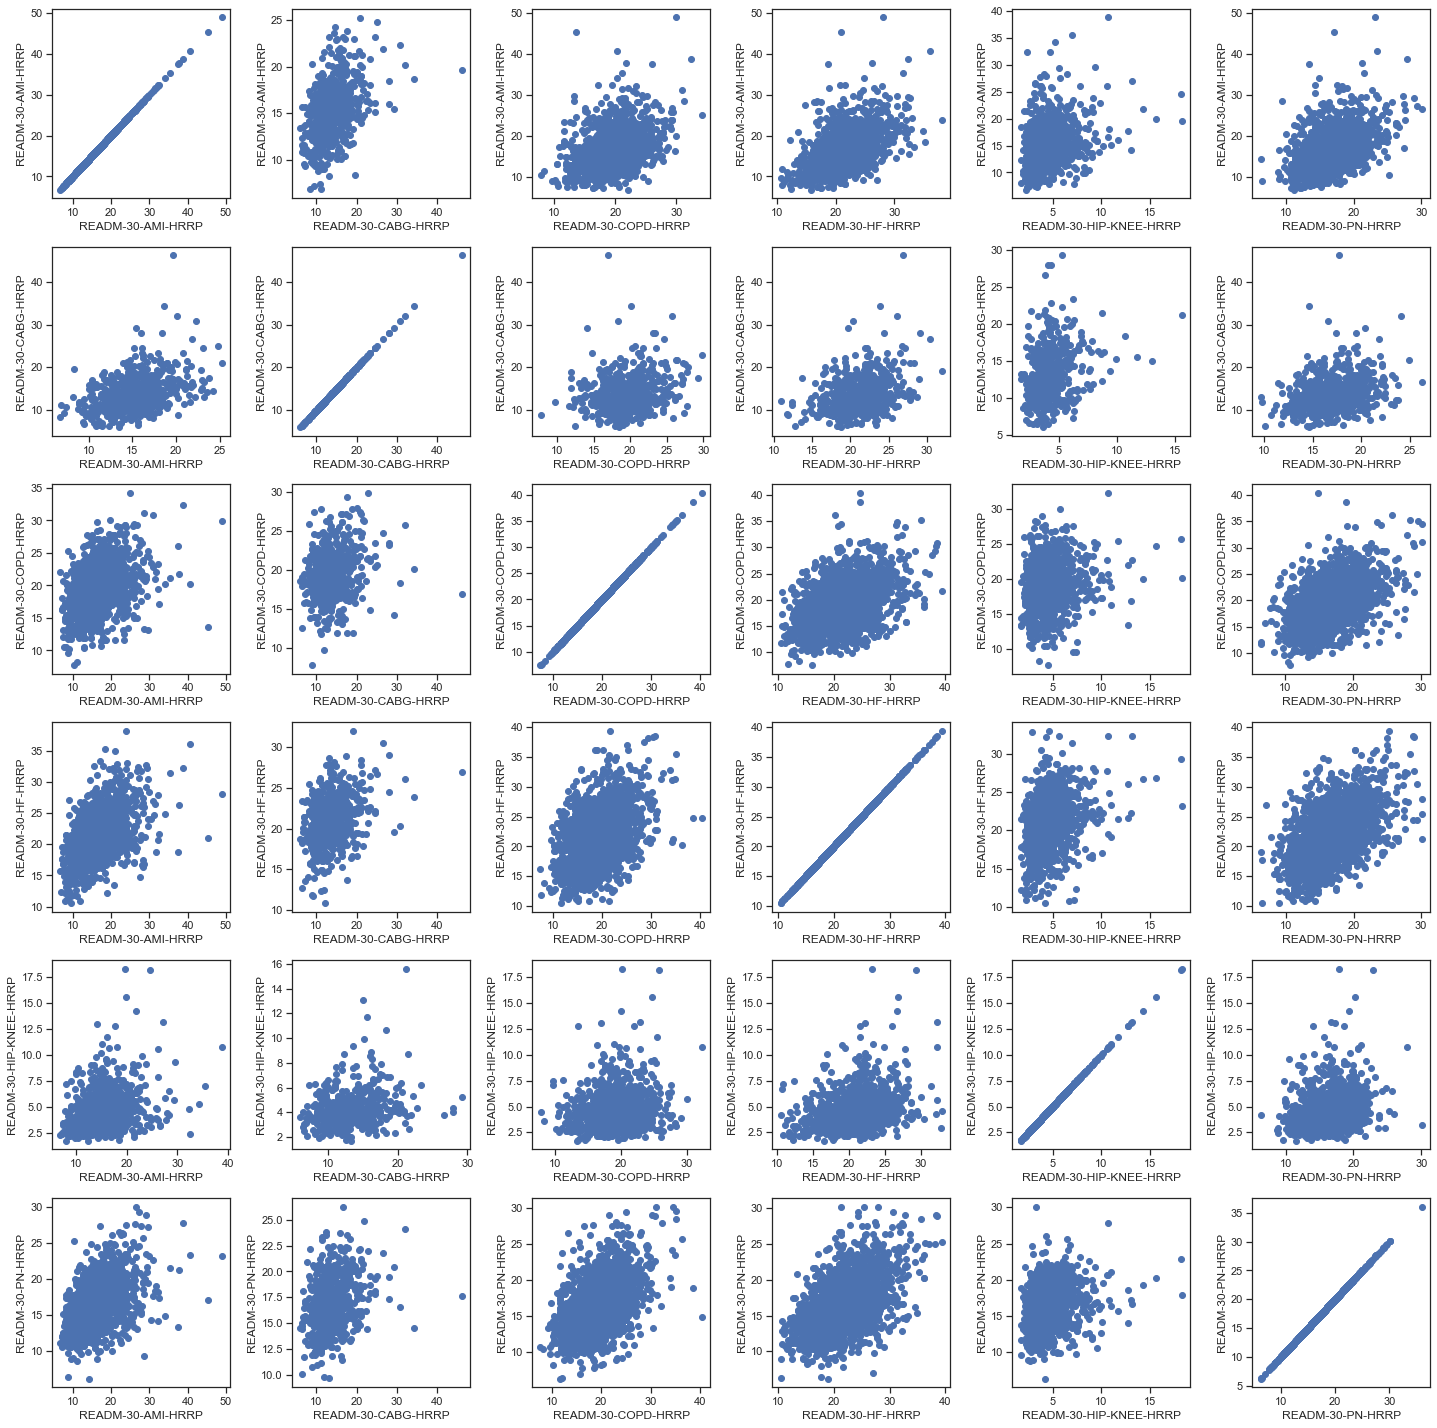

In [188]:
fig, axs = plt.subplots(6,6, figsize=(20,20))

new_diag_lst = diagnosis_lst * 6

other_diag_lst = []
for i in range(len(diagnosis_lst)):
    for _ in range(6):
        other_diag_lst.append(diagnosis_lst[i])

for i, ax in enumerate(axs.flatten()):
    x = d[new_diag_lst[i]][['Facility ID', 'Readmissions Rate']]
    y = d[other_diag_lst[i]][['Facility ID', 'Readmissions Rate']]
    merged = pd.merge(x,y, on='Facility ID', how='inner')
    ax.scatter(merged['Readmissions Rate_x'],merged['Readmissions Rate_y'])
    ax.set_xlabel(new_diag_lst[i])
    ax.set_ylabel(other_diag_lst[i])

plt.tight_layout()
fig.savefig('read rates correlation')